In [165]:
!pip install wordCloud

In [166]:
!pip install -U spacy

In [167]:
import re
import string
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report, confusion_matrix
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [168]:
df = pd.read_csv('/content/drive/MyDrive/ML PROJECTS/Fake job classifier/Dataset/fake_job_postings.csv')
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [169]:
df.shape

(17880, 18)

In [170]:
df.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [171]:
df = df.drop(['job_id', 'salary_range', 'has_company_logo', 'telecommuting', 'has_questions', 'employment_type'], axis = 1)

In [172]:
df.fillna('', inplace = True)

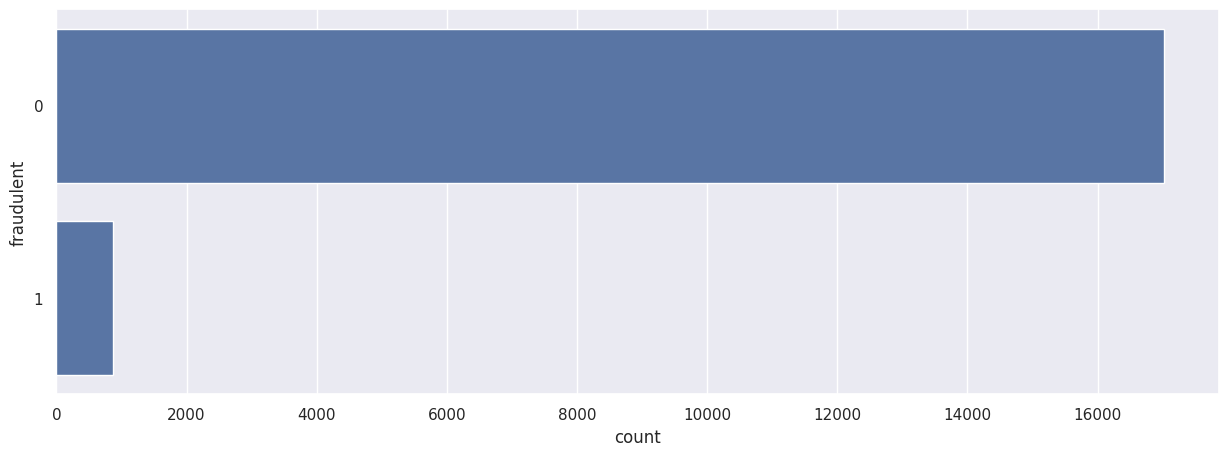

In [173]:
plt.figure(figsize = (15,5))
sns.countplot(y ='fraudulent', data = df)
plt.show()

In [174]:
df.groupby('fraudulent')['fraudulent'].count()

fraudulent
0    17014
1      866
Name: fraudulent, dtype: int64

In [175]:
exp = dict(df.required_experience.value_counts())
del exp['']

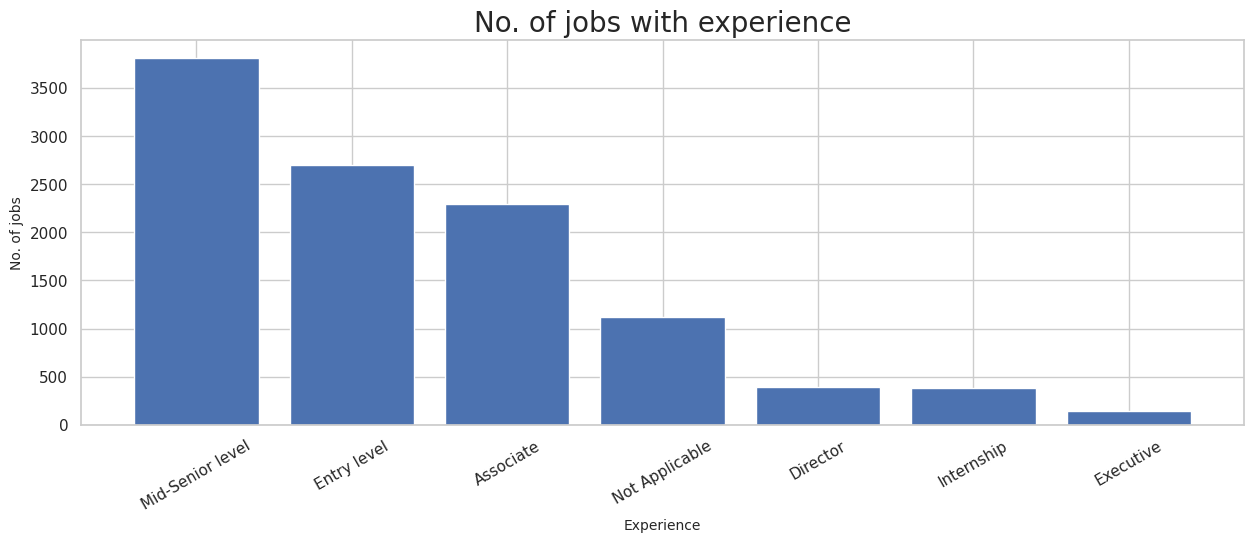

In [176]:
plt.figure(figsize = (15,5))
sns.set_theme(style = 'whitegrid')
plt.bar(exp.keys(),exp.values())
plt.title('No. of jobs with experience', size = 20)
plt.xlabel('Experience', size = 10)
plt.ylabel('No. of jobs', size = 10)
plt.xticks(rotation = 30)
plt.show()


In [177]:
def split(location):
  l = location.split(',')
  return l[0]

df['Country'] = df.location.apply(split)

In [178]:
df.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,Country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US


In [179]:
jobs_per_country = dict(df.required_education.value_counts()[:16])
del jobs_per_country['']
jobs_per_country

{"Bachelor's Degree": 5145,
 'High School or equivalent': 2080,
 'Unspecified': 1397,
 "Master's Degree": 416,
 'Associate Degree': 274,
 'Certification': 170,
 'Some College Coursework Completed': 102,
 'Professional': 74,
 'Vocational': 49,
 'Some High School Coursework': 27,
 'Doctorate': 26,
 'Vocational - HS Diploma': 9,
 'Vocational - Degree': 6}

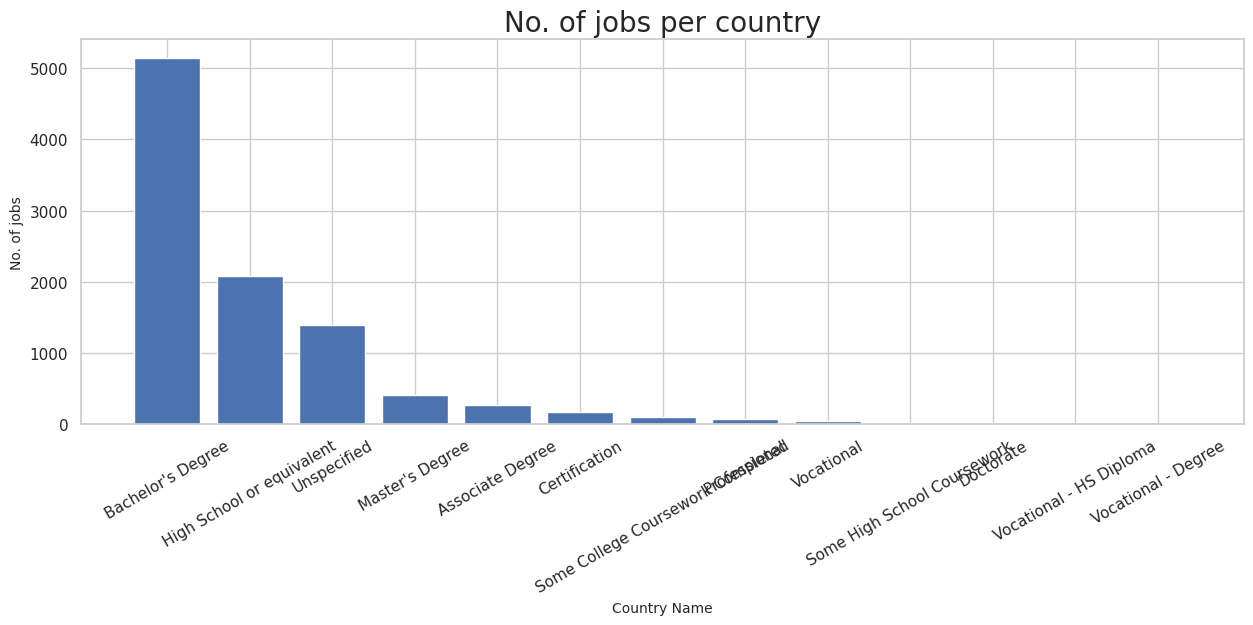

In [180]:
plt.figure(figsize = (15,5))
sns.set_theme(style = 'whitegrid')
plt.bar(jobs_per_country.keys(),jobs_per_country.values())
plt.title('No. of jobs per country', size = 20)
plt.xlabel('Country Name', size = 10)
plt.ylabel('No. of jobs', size = 10)
plt.xticks(rotation = 30)
plt.show()

In [181]:
edu_level = dict(df.required_education.value_counts()[:8])
del edu_level['']
edu_level

{"Bachelor's Degree": 5145,
 'High School or equivalent': 2080,
 'Unspecified': 1397,
 "Master's Degree": 416,
 'Associate Degree': 274,
 'Certification': 170,
 'Some College Coursework Completed': 102}

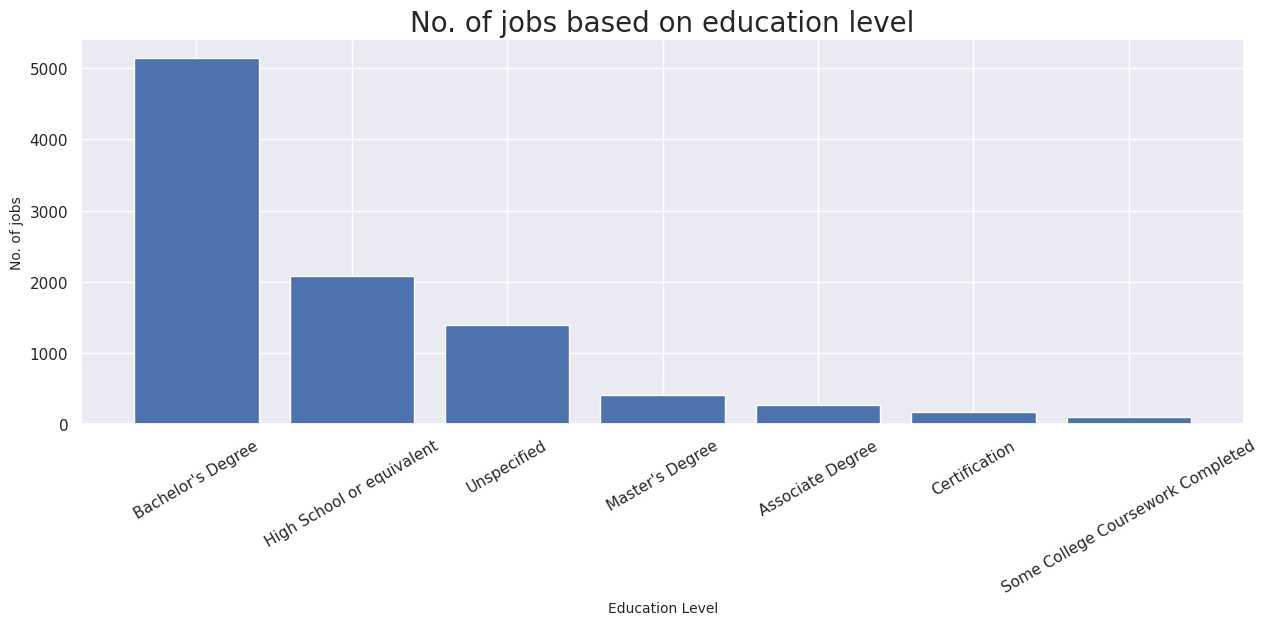

In [182]:
plt.figure(figsize = (15,5))
sns.set_theme(style = 'darkgrid')
plt.bar(edu_level.keys(),edu_level.values())
plt.title('No. of jobs based on education level', size = 20)
plt.xlabel('Education Level', size = 10)
plt.ylabel('No. of jobs', size = 10)
plt.xticks(rotation = 30)
plt.show()

In [183]:
print(df[df.fraudulent == 0].title.value_counts()[:11])

title
English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        73
Web Developer                                          66
Project Manager                                        62
Beauty & Fragrance consultants needed                  60
Name: count, dtype: int64


In [184]:
print(df[df.fraudulent == 1].title.value_counts()[:11])

title
Data Entry Admin/Clerical Positions - Work From Home                    21
Home Based Payroll Typist/Data Entry Clerks Positions Available         21
Cruise Staff Wanted *URGENT*                                            21
Customer Service Representative                                         17
Administrative Assistant                                                16
Home Based Payroll Data Entry Clerk Position - Earn $100-$200 Daily     12
Account Sales Managers $80-$130,000/yr                                  10
Network Marketing                                                       10
Payroll Clerk                                                           10
Payroll Data Coordinator Positions - Earn $100-$200 Daily               10
Data Entry                                                               9
Name: count, dtype: int64


In [185]:
df['text'] = df['title'] + ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits']
data = pd.DataFrame()
data['text'] = df['text']
data['fraudulent'] = df['fraudulent']

In [186]:
data.head()

,text,fraudulent
0,"Marketing Intern We're Food52, and we've creat...",0
1,Customer Service - Cloud Video Production 90 S...,0
2,Commissioning Machinery Assistant (CMA) Valor ...,0
3,Account Executive - Washington DC Our passion ...,0
4,Bill Review Manager SpotSource Solutions LLC i...,0


In [187]:
fraud_jobs_text = df[df.fraudulent == 1].text
real_jobs_text = df[df.fraudulent == 0].text

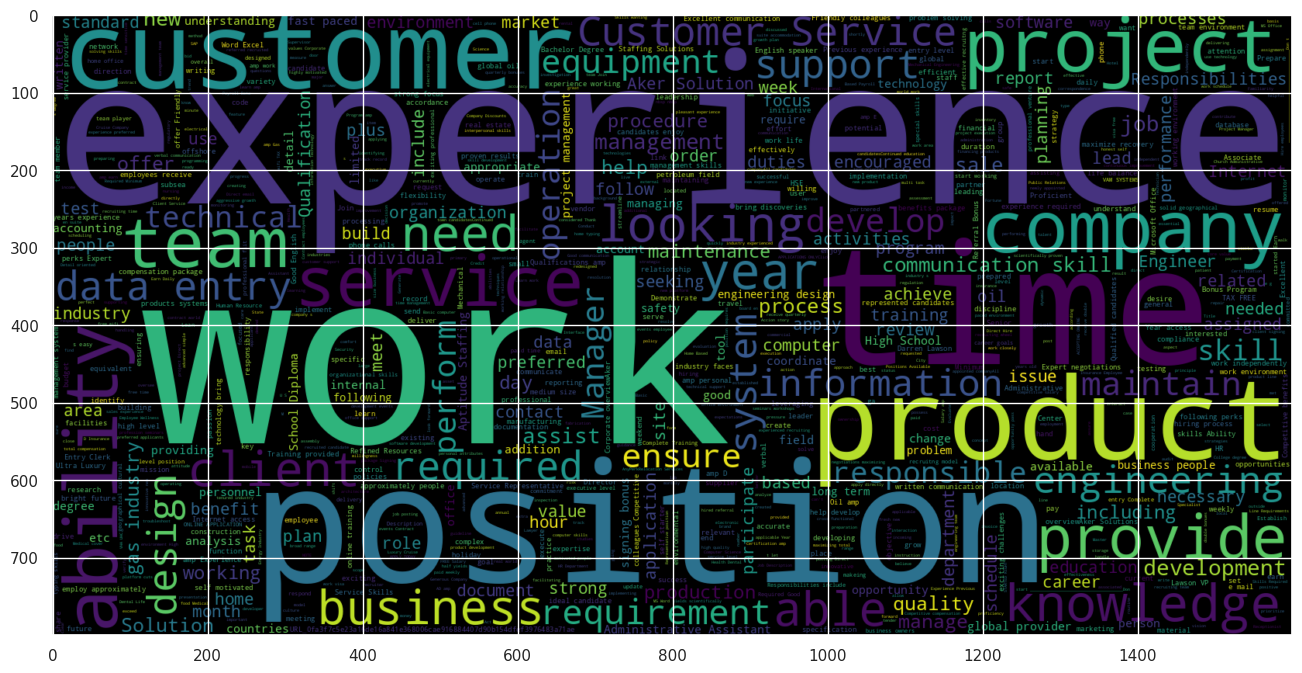

In [188]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size= 3, max_words= 3000, width = 1600, height = 800, stopwords = STOPWORDS).generate(str(" ".join(fraud_jobs_text)))
plt.imshow(wc, interpolation = 'bilinear')

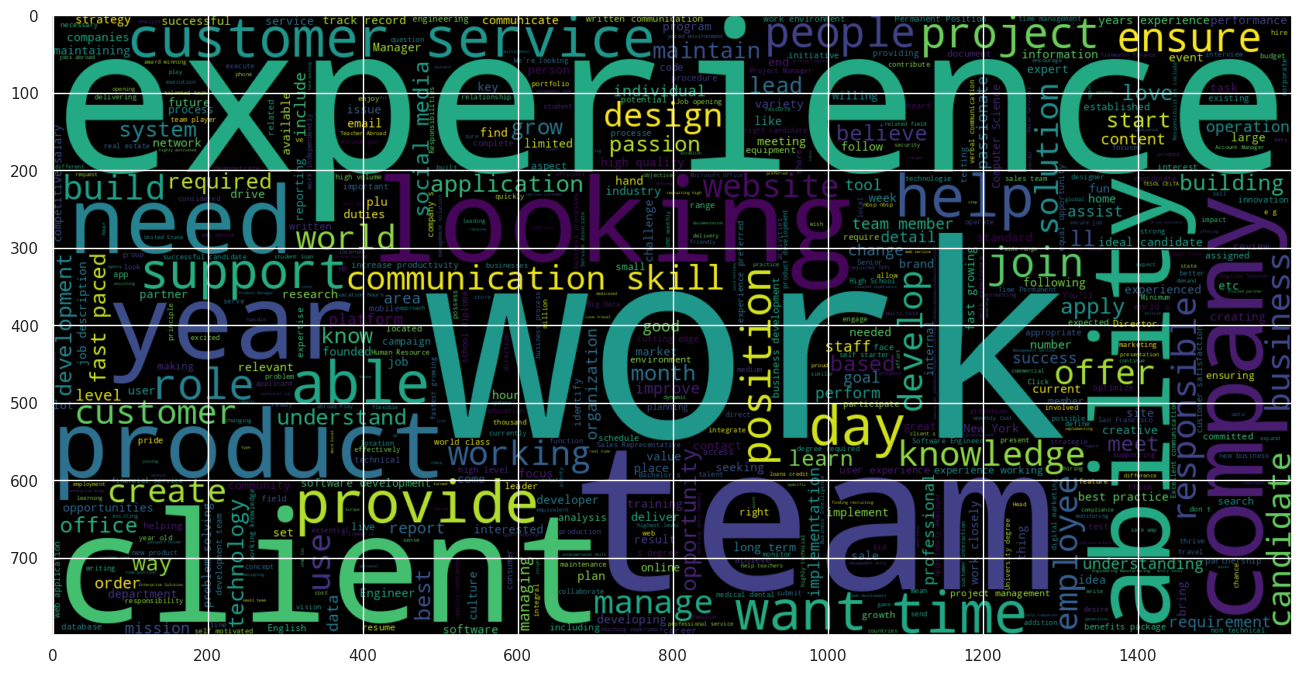

In [189]:
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size= 3, max_words= 3000, width = 1600, height = 800, stopwords = STOPWORDS).generate(str(" ".join(real_jobs_text)))
plt.imshow(wc, interpolation = 'bilinear')

In [190]:
!pip install spacy && python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 88.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [191]:
punctuations = string.punctuation

nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

parser = English()

def spacy_tokenizer(sentence):
  my_tokens = parser(sentence)
  my_tokens = [word.lemma.lower().strip() if word.lemma_ != "-PRON" else word.lower_ for word in my_tokens]
  my_tokens = [word for word in my_tokens if word not in stop_words and word not in punctuations]
  return my_tokens
class predictors(TransformerMixin):
  def transform(self, X, **transform_params):
    return [clean_text(text) for text in X]
  def fit(self, X, y=None, **fit_params):
    return self
  def get_params(self, deep = True):
    return {}
def clean_text(text):
  return text.strip().lower()


In [192]:
data['text'] = data['text'].apply(clean_text)

In [193]:
cv = TfidfVectorizer(max_features = 3000)
x = cv.fit_transform(data['text'])
data1 = pd.DataFrame(x.toarray(), columns = cv.get_feature_names_out())
data.drop(['text'], axis = 1, inplace = True)
main_df = pd.concat([data1,data], axis = 1)

In [194]:
main_df

,00,000,0in,10,100,1000,11,12,13,14,...,zealand,zero,για,και,με,να,σε,την,το,fraudulent
0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.081546,0.0,0.000000,0.032557,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.084267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,0.0,0.023900,0.0,0.022553,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
17876,0.0,0.000000,0.0,0.000000,0.027951,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
17877,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.042854,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
17878,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [195]:
X = main_df.iloc[:,:-1]
y = main_df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [196]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12516, 3000)
(5364, 3000)
(12516,)
(5364,)


In [197]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs = 3, oob_score = True, n_estimators= 100, criterion = 'entropy')
model = rfc.fit(X_train, y_train)

In [198]:
predictions = rfc.predict(X_test)
score = accuracy_score(y_test, predictions)
score

0.9753914988814317

In [199]:
print("Classification Report:")
print(classification_report(y_test, predictions))
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      5093
           1       1.00      0.51      0.68       271

    accuracy                           0.98      5364
   macro avg       0.99      0.76      0.83      5364
weighted avg       0.98      0.98      0.97      5364

Confusion Matrix:
[[5093    0]
 [ 132  139]]
